# 영어 word2vec 만들기

In [1]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

## 훈련 데이터 이해하기

In [2]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7f05d92a5e10>)

## 훈련 데이터 전처리하기

In [6]:
import nltk
nltk.download('punkt')

targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [8]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


## word2vec 훈련시키기

In [11]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

In [12]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8577309846878052), ('guy', 0.8243699669837952), ('boy', 0.7946793437004089), ('lady', 0.7743498086929321), ('gentleman', 0.7656912803649902), ('girl', 0.7591553330421448), ('soldier', 0.729931116104126), ('kid', 0.713019847869873), ('friend', 0.6691961884498596), ('son', 0.6585208177566528)]


## Word2Vec 모델 저장하고 로드하기

In [13]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [14]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8577309846878052), ('guy', 0.8243699669837952), ('boy', 0.7946793437004089), ('lady', 0.7743498086929321), ('gentleman', 0.7656912803649902), ('girl', 0.7591553330421448), ('soldier', 0.729931116104126), ('kid', 0.713019847869873), ('friend', 0.6691961884498596), ('son', 0.6585208177566528)]


# 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [16]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 53.3 MB/s 


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [18]:
# 네이버 영화 리뷰 데이터를 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f05b9ce2dd0>)

In [19]:
train_data = pd.read_table('ratings.txt')
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [20]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [22]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [23]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [24]:
print(len(train_data)) # 리뷰 개수 출력

199992


In [25]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [28]:
from tqdm import tqdm

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [16:04<00:00, 207.26it/s]


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


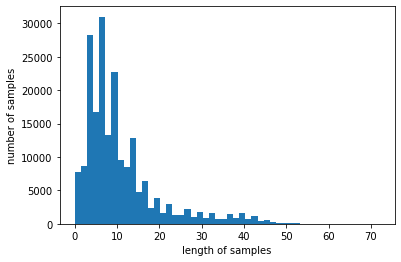

In [29]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :', max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :', sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [31]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [32]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.85953289270401), ('채민서', 0.8547847270965576), ('이주승', 0.8536484241485596), ('박중훈', 0.8488355278968811), ('서영희', 0.84473717212677), ('김명민', 0.8442007303237915), ('미스캐스팅', 0.8377963900566101), ('엄태웅', 0.8373895883560181), ('안성기', 0.836696207523346), ('송강호', 0.8340182304382324)]


In [33]:
print(model.wv.most_similar("히어로"))

[('무협', 0.8824073076248169), ('슬래셔', 0.8680009841918945), ('느와르', 0.8551814556121826), ('호러', 0.8519295454025269), ('정통', 0.8317621350288391), ('블록버스터', 0.8277259469032288), ('물', 0.8256007432937622), ('홍콩', 0.8134132027626038), ('물의', 0.8092231750488281), ('헐리우드', 0.803912878036499)]


## 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개

In [34]:
import gensim
import urllib.request

# 구글의 사전 훈련된 Word2Vec 모델을 로드.
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [35]:
print(word2vec_model.vectors.shape)

(3000000, 300)


In [36]:
print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

0.40797037
0.057204384


In [37]:
print(word2vec_model['book'])

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04